SIMPLEST possible application case: don't do any fine-tuning of existing model weights; just learn a frame-level decoder. Can we do it?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
torch.cuda.device_count()

1

In [7]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers
from transformers import AutoConfig
from transformers import Wav2Vec2Model
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from models import Vocabulary
from models.transformer import Wav2Vec2ForSpeechClassification, DataCollator, \
    drop_wav2vec_layers
from utils.timit import TimitCorpus

In [10]:
datasets.disable_caching()

In [12]:
model_dir = "out/pure_hugging/run5_drop6layers/checkpoint-850/"
device = "cuda:0"

In [17]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_dir).to(device)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at out/pure_hugging/run5_drop6layers/checkpoint-850/ and are newly initialized: ['wav2vec2.encoder.layers.8.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.10.attention.out_proj.weight', 'wav2vec2.encoder.layers.10.layer_norm.weight', 'wav2vec2.encoder.layers.8.attention.k_proj.weight', 'wav2vec2.encoder.layers.9.attention.v_proj.bias', 'wav2vec2.encoder.layers.7.attention.k_proj.weight', 'wav2vec2.encoder.layers.11.attention.q_proj.bias', 'wav2vec2.encoder.layers.7.attention.out_proj.bias', 'wav2vec2.encoder.layers.8.attention.out_proj.bias', 'wav2vec2.encoder.layers.8.final_layer_norm.weight', 'wav2vec2.encoder.layers.11.final_layer_norm.bias', 'wav2vec2.encoder.layers.10.final_layer_norm.bias', 'wav2vec2.encoder.layers.7.attention.k_proj.bias', 'wav2vec2.encoder.layers.8.attention.out_proj.weight', 'wav2vec2.encoder.layers.8.feed_forward.intermediate_dense.bias', 'wav2vec2.enco

In [18]:
corpus_path = "timit_corpus"

corpus = datasets.load_from_disk(corpus_path)
phone_vocab = Vocabulary.from_index2token(model.config.output_vocab)

In [19]:
processor = transformers.Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

In [20]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    label_mask, labels = p.label_ids

    def evaluate_label(j):
        preds_j = preds[:, :, j]
        labels_j = labels[:, :, j]

        preds_j = preds_j[label_mask == 1]
        labels_j = labels_j[label_mask == 1]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

In [21]:
coll = DataCollator(processor=processor, model=model, padding=True,
                    num_labels=len(phone_vocab.index2token))
training_args = TrainingArguments(
    do_train=False,
    do_eval=True,
    do_predict=True,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    use_cpu=device == "cpu",
    no_cuda=device == "cpu",
    output_dir=model_dir,
    resume_from_checkpoint=model_dir,
    label_names=["label_mask", "labels"],
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=coll,
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate

In [22]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    label_mask, labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

In [23]:
# Get optimal cut-off for each phone
optimal_thresholds = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, :, j]
    labels_j = labels[:, :, j]

    mask = label_mask == 1
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true posi

tensor([     inf,      inf,  -1.0245,  -3.1674,  -4.5643,  -3.3066, -11.5728,
         -5.6173, -10.5578,  -3.6191,   0.5110,  -0.7363,  -1.8278,  -5.6308,
         -1.3096,  -1.3588,  -3.1983,  -1.5000,  -4.6269,  -3.9396, -13.0457,
         -7.5154, -16.4447,      inf,  -4.9251,  -4.7326,   0.3035,  -1.1711,
         -1.1335,      inf, -10.0933,  -9.1354,  -1.6832,  -3.7790,   1.5442,
         -5.2634,   0.3823,   0.4570,  -1.1482,  -5.1976,  -3.0787,  -1.5793,
         -7.3979,  -5.9736,  -1.8809,  -3.1945,      inf,  -4.9057,  -6.9869,
          1.2993,   1.4627,  -3.9101,  -1.8731,  -2.1127,  -7.7385,  -6.7354,
         -5.5163,  -5.9224,  -3.9763,   5.0775,  -3.5881,  -4.4672,  -9.8364])

In [24]:
eval_predictions = trainer.predict(corpus["test"])

In [36]:
def add_predictions(batch, idxs):
    logits = eval_predictions.predictions[idxs]
    preds = (logits > optimal_thresholds.numpy()).astype(int)

    batch["score"] = logits
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds.numpy()
    batch["predicted"] = preds

    return batch

eval_result = corpus["test"].map(add_predictions, batched=True, batch_size=8, with_indices=True)

def compute_accuracy(item, idx):
    label_mask, labels = eval_predictions.label_ids
    label_mask = label_mask[idx] == 1
    labels = labels[idx]

    item["real_frames"] = label_mask.sum()
    item["correct"] = (np.array(item["predicted"])[label_mask] == labels[label_mask])
    item["fp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 0)
    item["fn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 1)
    item["tp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 1)
    item["tn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 0)
    item["accuracy"] = item["correct"].mean()
    return item

eval_result = eval_result.map(compute_accuracy, batched=False, with_indices=True)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [37]:
# DEV: because `TilingWordFeatureExtractor` does its own internal sorting, the phone
# targets don't actually match model internal targets, but rather the sorted phone
# vocabulary. Match this here in the viz.
viz_columns = sorted(phone_vocab.index2token)

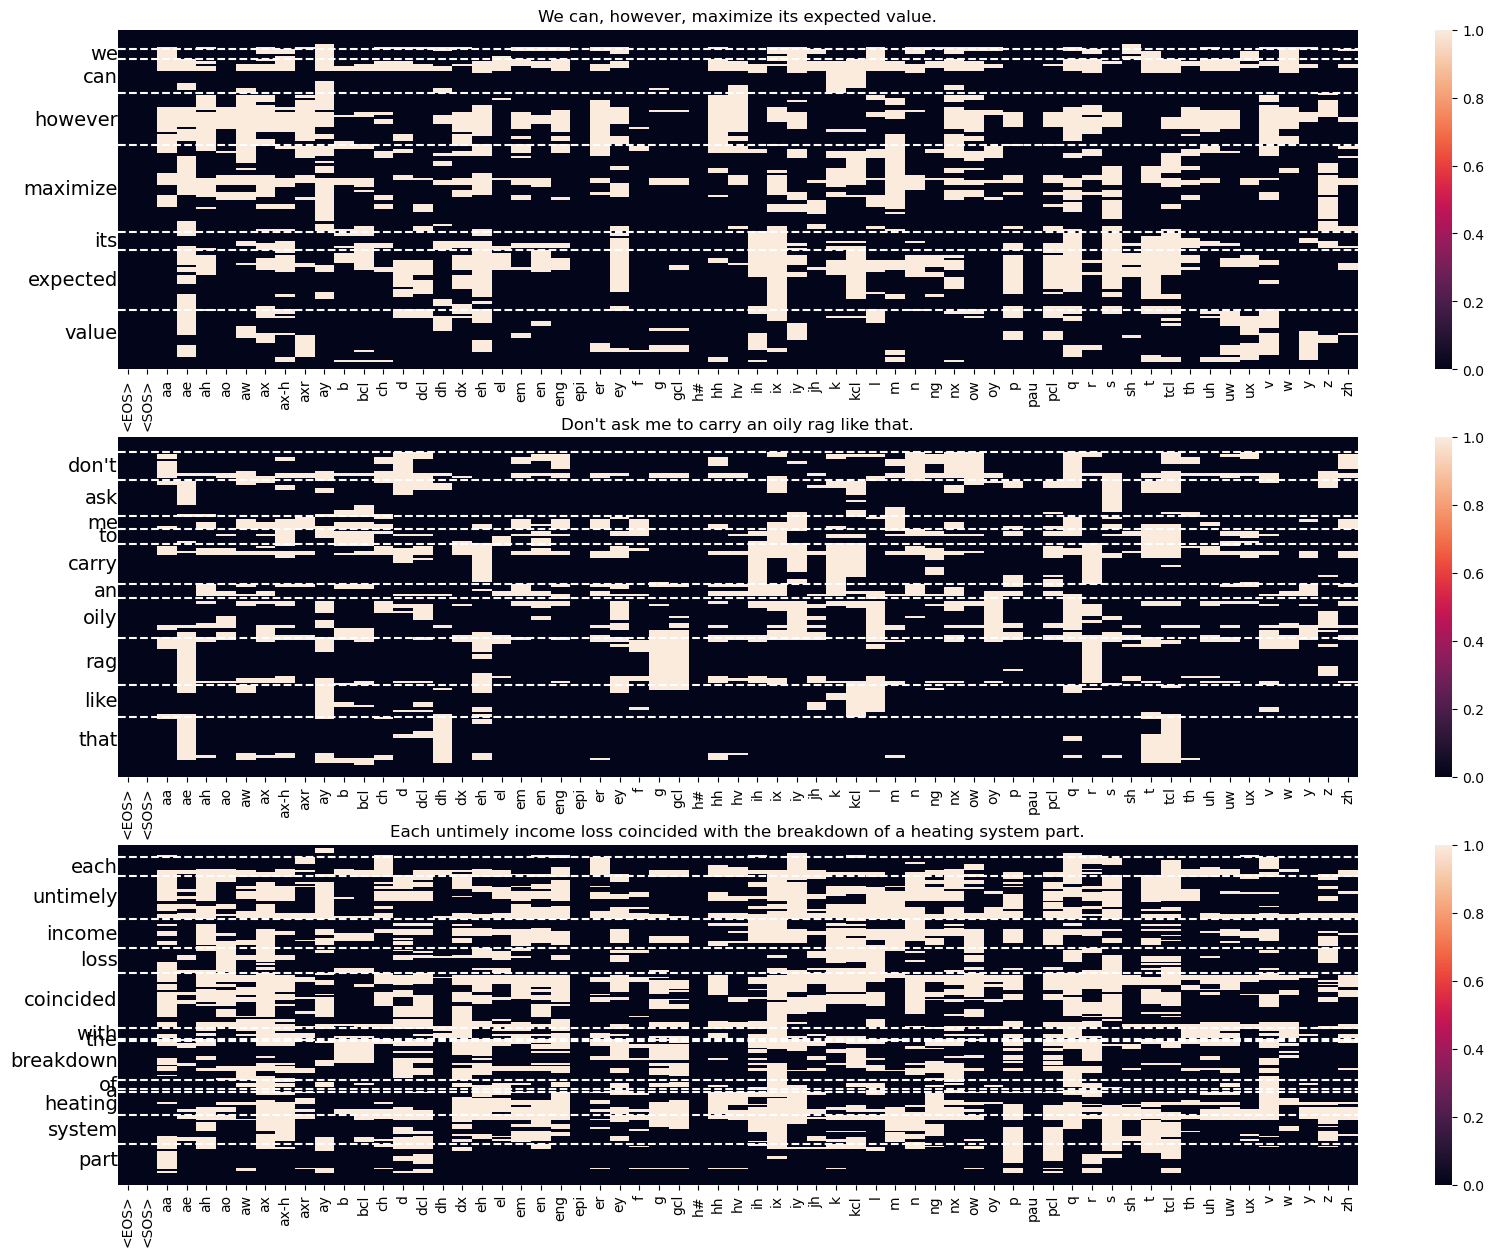

In [38]:
# viz phoneme predictions
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    result = pd.DataFrame(item["predicted"][:num_item_frames],
                          columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

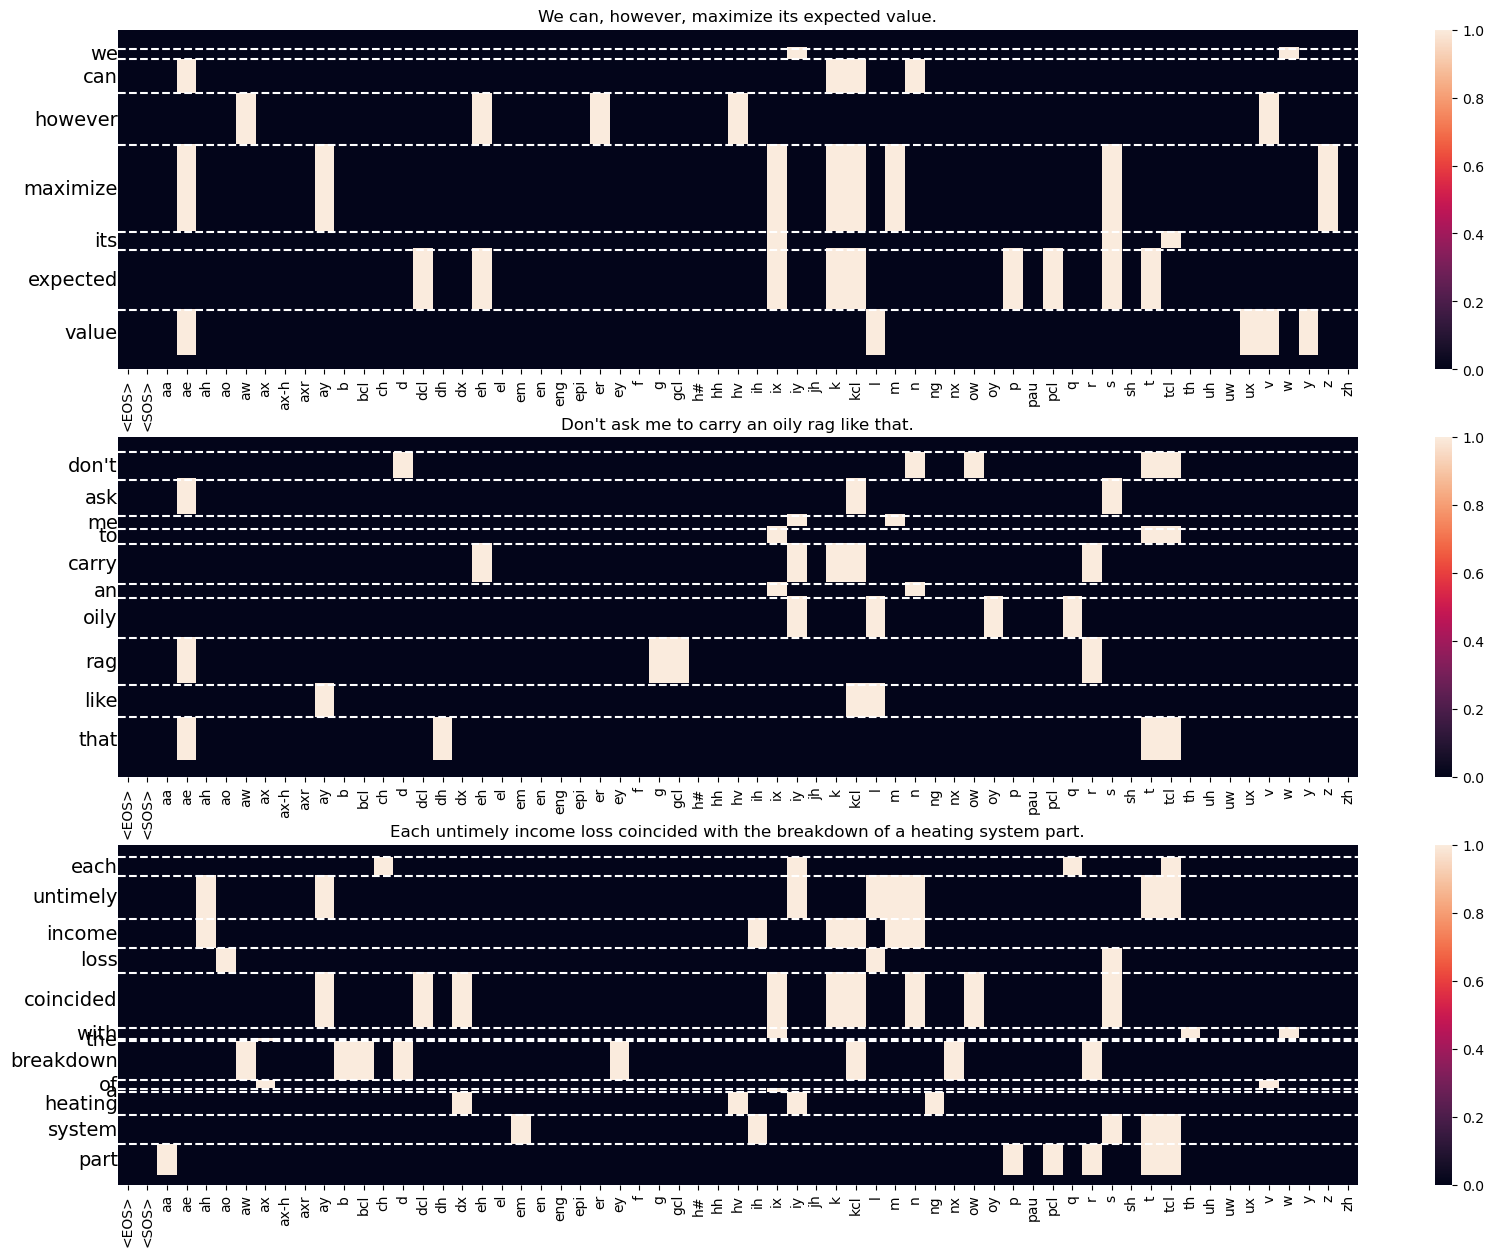

In [39]:
# viz labels
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
# Use same plot_idxs as above
# plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    label_mat = np.zeros_like(item["predicted"])
    for onset, offset, idx in item["phone_targets"]:
        onset = int(onset * compression_ratio)
        offset = int(offset * compression_ratio)
        label_mat[onset:offset, idx] = 1
    result = pd.DataFrame(label_mat[:num_item_frames], columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

In [43]:
item["phonetic_detail"]

{'start': [0,
  2280,
  2819,
  4211,
  4610,
  5827,
  6880,
  7596,
  8189,
  9090,
  11070,
  11960,
  12616,
  13953,
  14930,
  15694,
  16660,
  17370,
  18390,
  19563,
  20600,
  23060,
  24187,
  25020,
  26010,
  27321,
  28051,
  28820,
  30417,
  32439,
  32840,
  33420,
  34640,
  35342,
  35800,
  36840,
  37240,
  38210,
  38620,
  39200,
  40360,
  41700,
  42120,
  44280,
  44640,
  45266,
  46185,
  46937,
  48080,
  48960,
  49440,
  50040,
  51170,
  52770,
  53480,
  54308,
  54712,
  55495,
  56733,
  57580,
  57920,
  59663,
  61400,
  62210,
  62520],
 'stop': [2280,
  2819,
  4211,
  4610,
  5827,
  6880,
  7596,
  8189,
  9090,
  11070,
  11960,
  12616,
  13953,
  14930,
  15694,
  16660,
  17370,
  18390,
  19563,
  20600,
  23060,
  24187,
  25020,
  26010,
  27321,
  28051,
  28820,
  30417,
  32439,
  32840,
  33420,
  34640,
  35342,
  35800,
  36840,
  37240,
  38210,
  38620,
  39200,
  40360,
  41700,
  42120,
  44280,
  44640,
  45266,
  46185,
  469

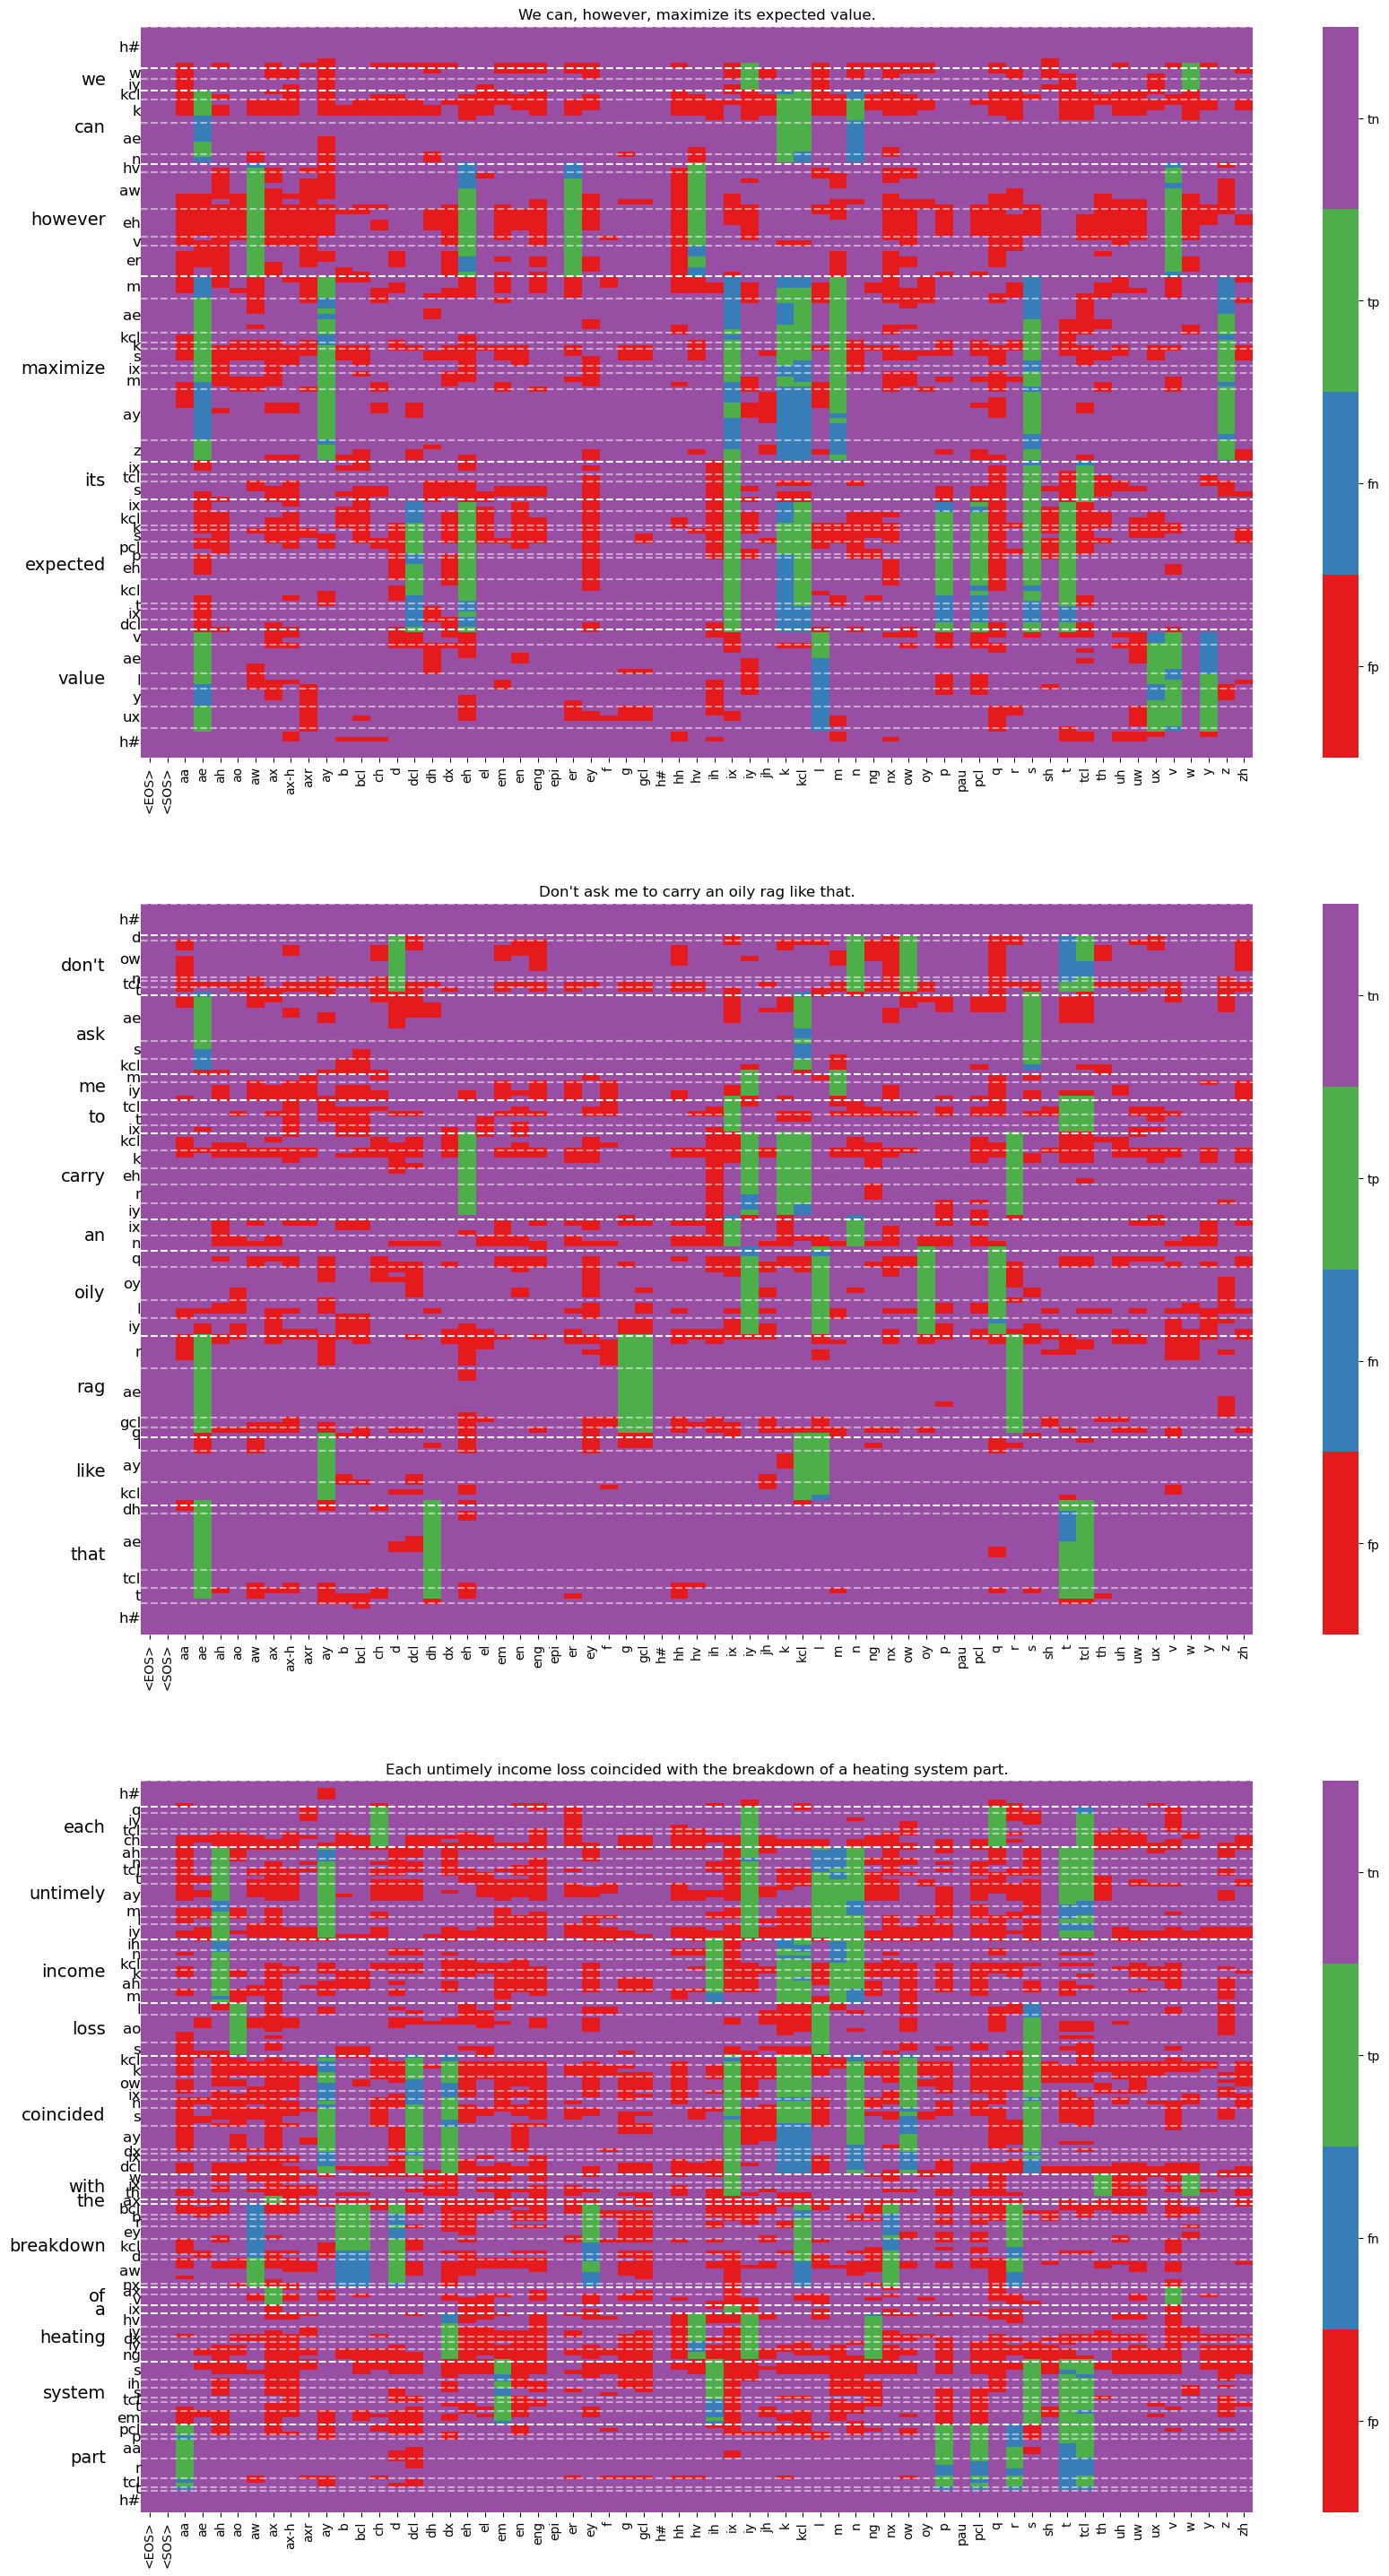

In [55]:
# viz labels
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 12 * n_to_plot))
# Use same plot_idxs as above
# plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    data = np.zeros_like(item["correct"]).astype(int)
    data[np.array(item["fp"])] = 1
    data[np.array(item["fn"])] = 2
    data[np.array(item["tp"])] = 3
    data[np.array(item["tn"])] = 4
    color_labels = ["fp", "fn", "tp", "tn"]

    # result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    result = pd.DataFrame(data[:num_item_frames], columns=viz_columns)
    sns.heatmap(result, ax=ax, cmap=sns.color_palette("Set1", 4))
    ax.set_title(item["text"])
    ax.set_yticks([])
    colorbar = ax.collections[0].colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 4 * (0.5 + i) for i in range(4)])
    colorbar.set_ticklabels(color_labels) 

    word_detail = item["word_detail"]
    word_starts = set()
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio
        word_starts.add(start)

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(-2, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    for i, (start, stop, phon) in enumerate(zip(item["phonetic_detail"]["start"], item["phonetic_detail"]["stop"], item["phonetic_detail"]["utterance"])):
        start = start * compression_ratio
        stop = stop * compression_ratio

        if start not in word_starts:
            ax.axhline(start, color="white", linestyle="--", alpha=0.5)
        
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, phon, ha="right", va="center", fontsize=12)

    # for y in np.linspace(*ax.get_ylim(), 5):
    #     ax.text(-1, y, f"{y:.2f}", ha="right", va="center", fontsize=14)